# Catalog optimization

### Initializing a SparkContext

In [209]:
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local[30]').setAppName('timeSeries')
sc = SparkContext(conf = conf)

# Get URL of Spark UI
sc.uiWebUrl

'http://instance-46395.bigstep.io:4042'

### General information about Spark

In [46]:
sc.version

'2.3.0'

In [47]:
!which pyspark

/opt/anaconda3/envs/jupyter/bin/pyspark


In [48]:
!echo $JAVA_HOME
!echo $SPARK_HOME
!echo $PYSPARK_PYTHON

/opt/jdk1.8.0_131
/opt/spark-2.3.0-bin-hadoop2.6
/opt/anaconda3/envs/python3/bin/python


## Catalog optimization

In [210]:
from pyspark.sql.types import StructField, StructType, StringType, FloatType, IntegerType, LongType, DateType, TimestampType
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.functions import udf
from pyspark.sql.types import *

struct = StructType([StructField('id', StringType()),
                     StructField('date', TimestampType()),
                     StructField('store_nbr', IntegerType()),
                     StructField('item_nbr', IntegerType()),
                     StructField('unit_sales', FloatType()),
                     StructField('onpromotion', StringType())])

train = sqlContext.read.load('/opt/notebooks/Projects/Kaggle/Retail_forecasting/data/train.csv',
                                format='com.databricks.spark.csv',
                                schema=struct,
                                header='true')

stores = sqlContext.read.load('/opt/notebooks/Projects/Kaggle/Retail_forecasting/data/stores.csv',
                                format='com.databricks.spark.csv',
                                inferSchema=True,
                                header='true')

items = sqlContext.read.load('/opt/notebooks/Projects/Kaggle/Retail_forecasting/data/items.csv',
                                format='com.databricks.spark.csv',
                                inferSchema=True,
                                header='true')

In [211]:
# Join datasets
data = train.join(stores, ["store_nbr"])
data = data.join(items, ["item_nbr"], "left")

In [407]:
from contextlib import contextmanager
import time

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

## 1.) Catalogue optimization for a single store (store 47)

In [212]:
# Select data for a single store
store_47 = data.filter('store_nbr == 47')
store_47.printSchema()

root
 |-- item_nbr: integer (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- unit_sales: float (nullable = true)
 |-- onpromotion: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)



In [213]:
# # This step may not even be necessary
# from pyspark.sql.functions import lit, last_day
# from pyspark.sql.functions import array, create_map, struct

# def create_date_columns(df):
#     df = df.withColumn('year', year('date'))
#     df = df.withColumn('month', month('date'))
#     df = df.withColumn('day', dayofmonth('date'))
#     df = df.withColumn('day_of_week', date_format('date', 'E'))
#     df = df.withColumn('month_end', last_day('date'))
#     return df

# store_47 = create_date_columns(store_47)

In [ ]:
store_47.createOrReplaceTempView('store47')

# Get first appearance date for the past two years
query_1 = "SELECT item_nbr, MIN(date) as first_appearance \
           FROM store47 \
           WHERE YEAR(date) in (2016, 2017) \
           GROUP BY item_nbr"

first_appearance = sqlContext.sql(query_1)
# Transfrom into pandas DataFrame
first_appearance = first_appearance.toPandas()
# Transform into pandas Series (key-value pair of SKU's and entry dates)
first_appearance = first_appearance.set_index('item_nbr', drop=True).squeeze()

query_2 = "SELECT item_nbr, MAX(date) as last_appearance \
           FROM store47 \
           WHERE YEAR(date)=2017 \
           GROUP BY item_nbr"

last_appearance = sqlContext.sql(query_2)
# Transfrom into pandas DataFrame
last_appearance = last_appearance.toPandas()
# Transform into pandas Series (key-value pair of SKU's and entry dates)
last_appearance = last_appearance.set_index('item_nbr', drop=True).squeeze()

In [ ]:
# Get new products for a specific month
def get_new_items(first_appearance, month, year):
    month_filter = first_appearance.apply(lambda x: x.month == month)
    year_filter = first_appearance.apply(lambda x: x.year == year)
    return first_appearance[(month_filter) & (year_filter)]

# get new items for May 2017
new_items = get_new_items(first_appearance, month=5, year=2017)

In [342]:
items_df = items.toPandas()
items_df = items_df.set_index('item_nbr', drop=True)

# a simple merge would also work
def get_item_family_and_class(new_items):
    family_list = []
    class_list = []
    for item in new_items.index:
        family_list.append(items_df.loc[item][0])
        class_list.append(items_df.loc[item][1])
    
    new_items = new_items.to_frame()
    new_items['family'] = family_list
    new_items['class'] = class_list    
    
    return new_items

new_items_df = get_item_family_and_class(new_items)

In [413]:
new_items_df

,first_appearence,family,class
item_nbr,,,
2084706,2017-05-15,HOME CARE,3104
2108843,2017-05-16,GROCERY I,1086
2089789,2017-05-15,BEAUTY,4254
2091318,2017-05-21,BEAUTY,4252
2059647,2017-05-02,HOME CARE,3106
2087374,2017-05-15,DAIRY,2162
2003392,2017-05-24,HOME AND KITCHEN I,6253
2053415,2017-05-01,GROCERY I,1082
1371395,2017-05-12,HOME AND KITCHEN I,6246


In [410]:
from datetime import datetime

with timer('One item: '):
    item_performance = {}
    for item_nbr, row in new_items_df.iterrows():
        if item_nbr == 2084706:
            first_date = datetime.strftime(row[0], '%Y-%m-%d')
            last_date = datetime.strftime(last_appearance[index], '%Y-%m-%d')
            item_class = row[2]

            item_sales = store_47.filter(r"item_nbr == {} and date >= '{}' and date <= '{}'".format(item_nbr, first_date, last_date))
            avg_item_sale = item_sales.groupby('item_nbr').mean('unit_sales').toPandas()

            class_sales = store_47.filter(r"class == {} and item_nbr != {} and date >= '{}' and date <= '{}'".format(item_class, item_nbr, first_date, last_date))
            avg_class_sale = class_sales.groupby('class').mean('unit_sales').toPandas()

            item_performance[item_nbr] = avg_item_sale.iloc[0, 1]/avg_class_sale.iloc[0, 1]

# avg_class_sale = avg. sale of products in specified class per day
# # avg_item_sale = avg. sale of item per day
# Perf = avg_item_sale/ avg_class_sale (on avg. how much more or less items were sold per day versus the class avg.)

One item:  - done in 132s


## 2.) Catalogue optimization for all stores

In [516]:
# First and last sale date per store_nbr, per item_nbr
query_1 = "SELECT store_nbr, item_nbr, MIN(date) as first_date, MAX(date) as last_date \
           FROM allSales \
           WHERE YEAR(date) in (2016, 2017) \
           GROUP BY store_nbr, item_nbr"

item_first_last_date = sqlContext.sql(query_1)
item_first_last_date.createOrReplaceTempView('firstLastSale')

def get_new_items(month, year):
    query = "SELECT store_nbr, item_nbr, first_date, last_date FROM firstLastSale \
             WHERE YEAR(first_date)={} and MONTH(first_date)={}".format(year, month)
    new_items = sqlContext.sql(query).toPandas() 
    return new_items
    
new_items = get_new_items(month=5, year=2017)

In [525]:
# Get class and family of all new products
items_df = items.toPandas()
new_items_df = new_items.merge(items_df[['item_nbr', 'family', 'class']], how='left', on='item_nbr')

In [581]:
new_items_df 

,store_nbr,item_nbr,first_date,last_date,family,class
0,13,1489882,2017-05-06,2017-08-15,PRODUCE,2018
1,27,221506,2017-05-07,2017-08-15,CLEANING,3046
2,52,1962694,2017-05-11,2017-07-22,PERSONAL CARE,4104
3,26,2088860,2017-05-12,2017-07-22,GROCERY I,1006
4,33,781936,2017-05-12,2017-05-15,MEATS,2302
5,52,2103250,2017-05-15,2017-08-13,BEAUTY,4254
6,51,2084278,2017-05-18,2017-08-15,BEVERAGES,1122
7,16,2042614,2017-05-01,2017-08-02,CLEANING,3028
8,30,1916209,2017-05-03,2017-05-06,GROCERY I,1026
9,54,2040862,2017-05-10,2017-07-22,BEVERAGES,1120


In [557]:
item_nbr_list = []
store_nbr_list = []
avg_item_sale_list = []
avg_class_sale_list = []

# Check for one item first
one_item_df = new_items_df[new_items_df['item_nbr'] == 1489882]

with timer('One new item: '):
    for index, row in one_item_df.iterrows():
        store_nbr = row[0]
        item_nbr = row[1]
        item_class = row[5]

        store_nbr_list.append(store_nbr)
        item_nbr_list.append(item_nbr)

        first_date = datetime.strftime(row[2], '%Y-%m-%d')
        last_date = datetime.strftime(row[3], '%Y-%m-%d')

        item_sales = data.filter(r"item_nbr == {} and store_nbr == {} and date >= '{}' and date <= '{}'".format(item_nbr, store_nbr, first_date, last_date))
        avg_item_sale = item_sales.groupby('item_nbr').mean('unit_sales').toPandas()
        avg_item_sale_list.append(avg_item_sale.iloc[0][1])

        class_sales = data.filter(r"item_nbr != {} and store_nbr == {} and class == {} and date >= '{}' and date <= '{}'".format(item_nbr, store_nbr, item_class, first_date, last_date))
        avg_class_sale = class_sales.groupby('class').mean('unit_sales').toPandas()
        avg_class_sale_list.append(avg_class_sale.iloc[0][1])
        print('Store number {} finished.'.format(store_nbr))
        
    results = pd.DataFrame({'item_nbr':item_nbr_list,
                            'avg_item_sale':avg_item_sale_list,
                            'store_nbr':store_nbr_list,
                            'avg_class_sale':avg_class_sale_list})
    

Store number 13 finished.
Store number 15 finished.
Store number 30 finished.
Store number 17 finished.
Store number 43 finished.
Store number 33 finished.
Store number 20 finished.
Store number 14 finished.
Store number 22 finished.
Store number 12 finished.
Store number 11 finished.
Store number 34 finished.
Store number 28 finished.
Store number 35 finished.
Store number 16 finished.
Store number 9 finished.
Store number 31 finished.
Store number 39 finished.
Store number 21 finished.
Store number 29 finished.
Store number 18 finished.
Store number 10 finished.
One new item:  - done in 2957s


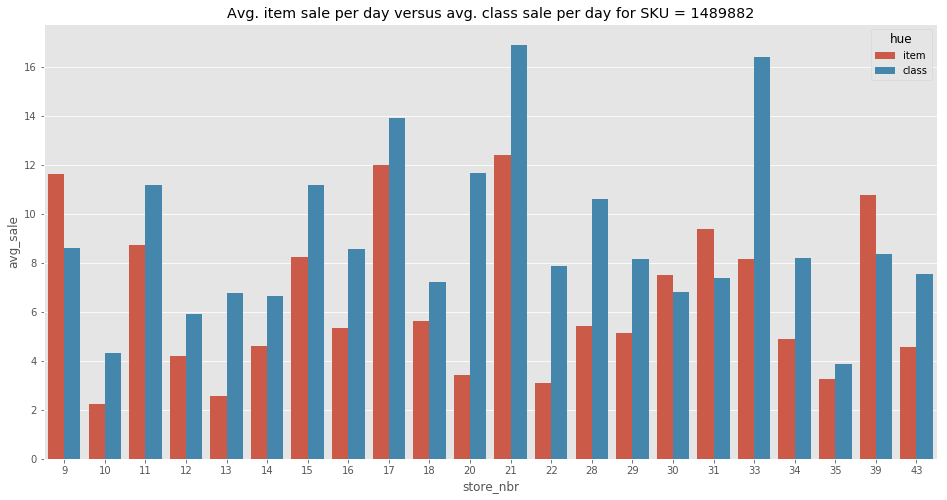

In [583]:
# Seaborn works with wideform data
results_long = pd.DataFrame({'store_nbr':store_nbr_list + store_nbr_list,
                             'avg_sale':avg_item_sale_list + avg_class_sale_list,
                             'hue':['item' for x in item_nbr_list]+ ['class' for x in item_nbr_list]})

import matplotlib.pyplot as plt
import seaborn as sns

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x='store_nbr', y='avg_sale', hue='hue', data=results_long, ax=ax)
    ax.set_title('Avg. item sale per day versus avg. class sale per day for SKU = 1489882')
    plt.show()